In [17]:
import os
import sys
sys.path.append("../")
import torch.nn as nn
import numpy as np
from random import shuffle
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
from tqdm import tqdm
# from preprocess.focal_loss import FocalLoss
# from utils.svdd_loss import SVDDLoss
from dataloader.svdd_dataloader import CollisionLoader_new  
# from nets.svdd_net import FusionNet
from baseline_lstm_svdd_net import FusionNet
from reconstruction_loss import ReconstructionLoss
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
torch.manual_seed(42)
np.random.seed(42)
%matplotlib inline
torch.manual_seed(42)
np.random.seed(42)

train_audio_path = '../../data/audio/normal_test'
train_imu_path = '../../data/imu/normal_test'

test_audio_path = '../../data/audio/abnormal'
test_imu_path = '../../data/imu/abnormal'

checkpoint_path = '/home/iot/collision_detect/output/baselinemodel/svdd_0_/lstm_svdd_last_model.pth'
save_path = '/home/iot/collision_detect/output'
workers = 4
batchsize = 64
dropout_rate = 0.3
kernel_num = 32
feature_dim = 512
num_class = 2
use_attention = 0
Epoch = 200
hidden_dim = 64  # LSTM隐藏层维度
num_layers = 2  # LSTM层数
save_name = "svdd_{}_".format(use_attention)
save_dir = os.path.join(save_path, save_name)
os.makedirs(save_dir, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
reconstruction_loss_fn = ReconstructionLoss()
loss_function = nn.MSELoss()


train_data = CollisionLoader_new(train_imu_path,train_audio_path)
val_data   = CollisionLoader_new(test_imu_path,test_audio_path)
train_dataloader = DataLoader(train_data, batchsize, shuffle=True, num_workers=workers, drop_last=True)
val_dataloader   = DataLoader(val_data, batchsize, shuffle=True, num_workers=workers, drop_last=True)

random_tensor = torch.load('center.pth').to(device)
print(random_tensor)
model = FusionNet(use_crossattention=use_attention, feature_dim=feature_dim, dropout_rate=dropout_rate, kernel_num=kernel_num, classes=num_class)
model = model.to(device)

if checkpoint_path != '':
    model.load_state_dict(torch.load(checkpoint_path))
model.eval()
sample_idx = 405

cuda
tensor([ 0.1768, -0.2452, -2.9501,  ..., -0.0816,  0.6419,  1.4178],
       device='cuda:0')


In [18]:
model.eval()
sample_idx = 40
# Change this to the index of the sample you want to load
spec, image, audio = train_data[sample_idx]
spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)

anomaly_score = model(audio, image)

target_zero = random_tensor.unsqueeze(0).expand(1, -1)
svdd_loss = loss_function(anomaly_score, target_zero)
print(svdd_loss)

tensor(6.5569e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


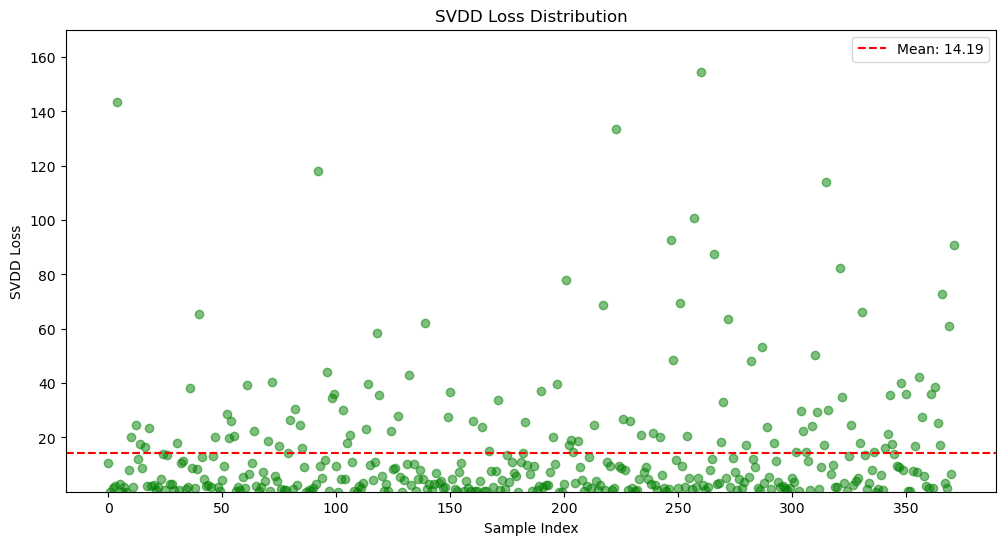

In [19]:
import matplotlib.pyplot as plt

# Initialize lists to store individual loss values
reconstruction_losses = []
svdd_losses = []
total_losses = []

# Iterate over the dataset to collect individual losses
with torch.no_grad():
    for sample_idx in range(len(train_data)):
        spec, image, audio = train_data[sample_idx]
        spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)

        # Forward pass through the model
        anomaly_score = model(audio, image)

        # Generate random tensor for SVDD loss
        target_zero = random_tensor.unsqueeze(0).expand(spec.size(0), -1)

        # Calculate SVDD loss for the sample
        svdd_loss = loss_function(anomaly_score, target_zero)*1000000
        svdd_losses.append(svdd_loss.item())

# Plotting the data distribution of losses using scatter plots
mean_svdd_loss = sum(svdd_losses) / len(svdd_losses)


# Plotting the data distribution of losses using scatter plots
plt.figure(figsize=(12, 6))


# plt.subplot(1, 3, 2)
plt.scatter(range(len(train_data)), svdd_losses, color='green', alpha=0.5)
plt.axhline(y=mean_svdd_loss, color='red', linestyle='--', label=f'Mean: {mean_svdd_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('SVDD Loss')
plt.title('SVDD Loss Distribution')
plt.ylim(min(svdd_losses), max(svdd_losses)*1.1)
plt.legend()


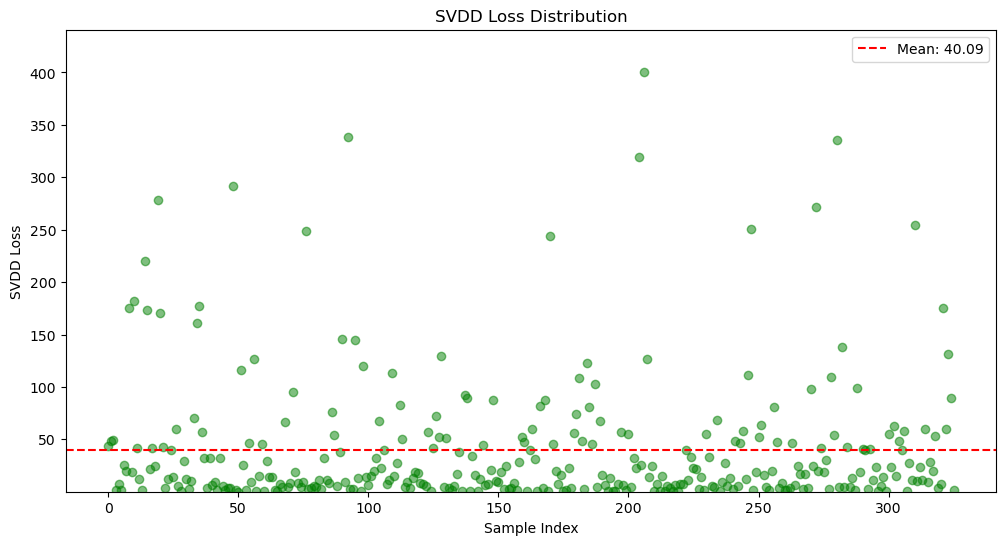

In [36]:
import matplotlib.pyplot as plt

# Initialize lists to store individual loss values
reconstruction_losses = []
svdd_losses = []
total_losses = []

# Iterate over the dataset to collect individual losses
with torch.no_grad():
    for sample_idx in range(len(val_data)):
        spec, image, audio = val_data[sample_idx]
        spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)

        # Forward pass through the model
        anomaly_score = model(audio, image)

        # Generate random tensor for SVDD loss
        target_zero = random_tensor.unsqueeze(0).expand(spec.size(0), -1)

        # Calculate SVDD loss for the sample
        svdd_loss = loss_function(anomaly_score, target_zero)*1000000
        svdd_losses.append(svdd_loss.item())

# Plotting the data distribution of losses using scatter plots
mean_svdd_loss = sum(svdd_losses) / len(svdd_losses)


# Plotting the data distribution of losses using scatter plots
plt.figure(figsize=(12, 6))


# plt.subplot(1, 3, 2)
plt.scatter(range(len(val_data)), svdd_losses, color='green', alpha=0.5)
plt.axhline(y=mean_svdd_loss, color='red', linestyle='--', label=f'Mean: {mean_svdd_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('SVDD Loss')
plt.title('SVDD Loss Distribution')
plt.ylim(min(svdd_losses), max(svdd_losses)*1.1)
plt.legend()


In [33]:
from sklearn.metrics import confusion_matrix
import numpy as np
model.eval()
random_tensor = torch.load('center.pth').to(device)
true_labels = []
predicted_labels = []
threshold = 0.45

with torch.no_grad():
    for sample_idx in range(len(val_data)):
        spec, image, audio = val_data[sample_idx]

        spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)
        anomaly_score = model(audio, image)

        target_zero = random_tensor.unsqueeze(0).expand(spec.size(0), -1)

        # Calculate SVDD loss for the sample
        svdd_loss = loss_function(anomaly_score, target_zero)*1000000


        # Predict class based on total loss
        if svdd_loss>=14.19:
            predicted_class=1
        else:
            predicted_class=0

        # Handle ground truth class
        true_class = 1 

        # Update confusion matrix variables
        true_labels.append(true_class)
        predicted_labels.append(predicted_class)

    for sample_idx in range(len(train_data)):
        spec, image, audio = train_data[sample_idx]

        spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)
        anomaly_score = model(audio, image)

        target_zero = random_tensor.unsqueeze(0).expand(spec.size(0), -1)

        # Calculate SVDD loss for the sample
        svdd_loss = loss_function(anomaly_score, target_zero)*1000000


        # Predict class based on total loss
        if svdd_loss>=14.19:ax(svdd_losses)*1.1
            predicted_class=1
        else:
            predicted_class=0

        # Handle ground truth class
        true_class = 0 

        # Update confusion matrix variables
        true_labels.append(true_class)
        predicted_labels.append(predicted_class)

# Construct confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)
print(conf_matrix.shape)

Confusion Matrix:
[[262 110]
 [154 172]]
(2, 2)


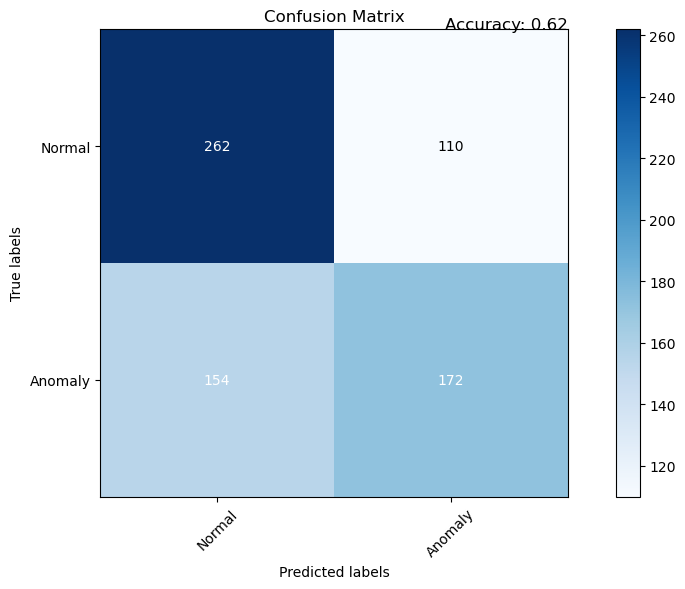

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Define class names
class_names = ['Normal', 'Anomaly']

# Calculate accuracy
accuracy = np.trace(conf_matrix) / float(np.sum(conf_matrix))

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Add counts to each cell
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

# Add accuracy to the plot
plt.text(1.5, -0.5, f'Accuracy: {accuracy:.2f}', color='black', fontsize=12, horizontalalignment='right')

# Eliminate grid lines
plt.grid(False)

plt.tight_layout()
plt.show()
